In [155]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn 
import statistics

#### Обработчик данных

In [159]:
class PrepareDate():
    # в констуркоре определим методы обработки данных
    def __init__(self, df_output):
        self.df_output = df_output

    # расчет затрат
    # (количество топлива (http://newsruss.ru/doc/index.php/Расход_топлива_у_самолётов) * минуты  )
    # * стоимость топлива (https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7379) - 51 859
    #  для самолтатов  Boeing 737-300 - 40 кг/1 мин, Sukhoi Superjet-100 - 28 кг / 1 мин
    def calculatePetrol(self):
        self.df_output['petrol'] = 0
        self.df_output.loc[(self.df_output['plane_model'] == 'Boeing 737-300'), 'petrol'] = 40
        self.df_output.loc[(self.df_output['plane_model'] == 'Sukhoi Superjet-100'), 'petrol'] = 28

        self.df_output['cost_petrol'] = (self.df_output['petrol'] * self.df_output['duration_minutes']) / 1000 * 51859
        self.calcululateTotalCosts()

    # так как общих затрат я не нашел - буду исходить из процентого соотношения затрат (https://www.aex.ru/docs/1/2011/4/13/1323/)
    #  топливо - 20% (оно нам известно  - примем за константу)
    #  аэропортовые сборы, наземное обслуживание, аэронавигация  примем на 20% (равно типливу)
    #  лизинговые и таможенные платежи, расходы на обслуживание кредита примем на 20% (равно типливу)
    #  техническое обслуживание парка авиасудов примем на 10% (равно половину типливу)
    #  расходы на оплату труда пилотного состава на 10% (равно половину типливу)
    #  todo общиие затраты =  4 * (затраты топлива)
    def calcululateTotalCosts(self):
        self.df_output['Costs'] = 4 * self.df_output['cost_petrol']

    #  извлечение даты
    def foramedDate(self):
        self.df_output['date_departure'] = pd.to_datetime( self.df_output['date_departure'], format='%d-%m-%Y %H:%M:%S')
        self.df_output['day_of_week'] =  self.df_output['date_departure'].dt.dayofweek
        self.df_output['month'] =  self.df_output['date_departure'].dt.month

    #  извлечение разных метрик
    def calculateProfit(self):
        # общая прибыль = продажа билетов - затраты
        self.df_output['profit'] =  self.df_output['pass_summ'] - self.df_output['Costs']
        #  заполняемость мест в т.ч. бизнес и экном классов
        self.df_output['occupancy'] = self.df_output['pass_count'] / self.df_output['plane_count']
        self.df_output['occupancy_econom'] = self.df_output['pass_econom_count'] / self.df_output['plane_econom_count']
        self.df_output['occupancy_bisness'] = self.df_output['pass_bisiness_count'] / self.df_output['plane_bisiness_count']

         # доля продажи  бизнес и экном билетов от общей продажи билетов
        self.df_output['part_bisness'] = self.df_output['pass_bisiness_summ'] / self.df_output['pass_summ']
        self.df_output['part_econom'] = self.df_output['pass_econom_summ'] / self.df_output['pass_summ']

        # как один пассажир влияет на доходность / или на продажу билетов
        self.df_output['deposit_profit'] = (self.df_output['profit'] )/ self.df_output['pass_count']
        self.df_output['deposit_econom'] = (self.df_output['pass_econom_summ'] )/ self.df_output['pass_econom_count']
        self.df_output['deposit_bisness'] = (self.df_output['pass_bisiness_summ'] )/ self.df_output['pass_bisiness_count']


    def processData(self):
        self.calculatePetrol()
        self.foramedDate()
        self.calculateProfit()

        return self.df_output

# Загрузка данных:

In [160]:
data = pd.read_csv('data.csv')

df_object = PrepareDate(data)
df = df_object.processData()

In [161]:
df.sample(5)

,flight_id,date_departure,duration_minutes,departure_city,departure_lon,departure_lat,city,arrival_lon,arrival_lat,plane_model,...,month,profit,occupancy,occupancy_econom,occupancy_bisness,part_bisness,part_econom,deposit_profit,deposit_econom,deposit_bisness
72,136452,2017-02-17 10:08:00,100,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,2,773256.000,0.838462,0.830508,0.916667,0.251154,0.748846,7094.091743,12248.979592,36600.0
7,136486,2017-02-02 10:07:00,101,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,2,667358.560,0.823077,0.838983,0.666667,0.194500,0.805500,6236.995888,12248.484848,36600.0
26,136632,2017-01-07 12:42:00,51,Anapa,37.347301,45.002102,Belgorod,36.590099,50.643799,Sukhoi Superjet-100,...,1,418081.392,0.938144,0.941176,0.916667,0.291054,0.708946,4594.301011,6330.000000,18900.0
8,136546,2017-01-03 06:13:00,302,Anapa,37.347301,45.002102,Novokuznetsk,86.877197,53.811401,Boeing 737-300,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,136387,2017-01-19 10:08:00,99,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,1,953553.440,0.930769,0.923729,1.000000,0.247437,0.752563,7880.606942,12255.045872,36600.0


***Количество рейсов:***


<AxesSubplot:ylabel='city'>

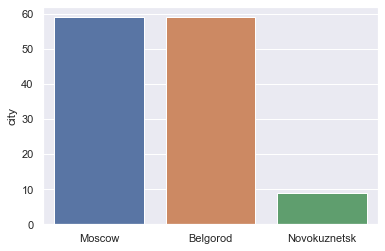

In [162]:
seaborn.barplot(x=df['city'].value_counts().index, y=df['city'].value_counts())

<AxesSubplot:ylabel='day_of_week'>

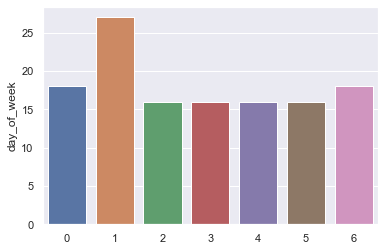

In [163]:
seaborn.barplot(x=df['day_of_week'].value_counts().index, y=df['day_of_week'].value_counts())

<AxesSubplot:ylabel='month'>

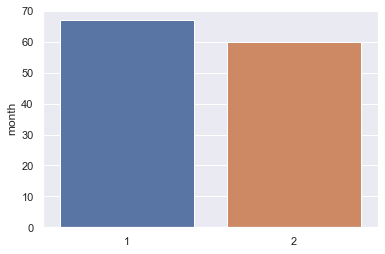

In [164]:
seaborn.barplot(x=df['month'].value_counts().index, y=df['month'].value_counts())

***Вывод:*** <br> Видно, что большинство рейсов в Москву и Белгород <br>
Количество рейсов по дням недели также примерно одинаково, кроме Вторника - рейсов больше! <br>
Также видно в декабре рейсов не было!

### Анализ направлений
Среднне время полета

<AxesSubplot:xlabel='city'>

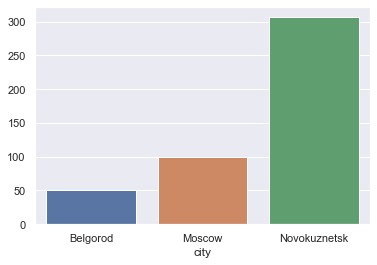

In [165]:
dff = df.groupby(['city'])['duration_minutes'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

In [166]:
dff = df.groupby('city')['plane_model'].unique()
dff

city
Belgorod        [Sukhoi Superjet-100]
Moscow               [Boeing 737-300]
Novokuznetsk         [Boeing 737-300]
Name: plane_model, dtype: object

### Таким образом для каждого города назначения летает только один тип самолета!

Среднняя стоимость билетов пассажиров  по городам: 

<AxesSubplot:xlabel='city'>

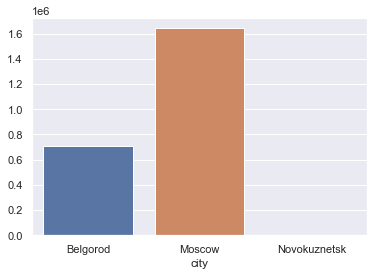

In [167]:
dff = df.groupby(['city'])['pass_summ'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

In [168]:
df[df['city'] == 'Novokuznetsk'][['pass_econom_summ', 'pass_bisiness_summ', 'pass_summ']]

,pass_econom_summ,pass_bisiness_summ,pass_summ
8,NaN,NaN,NaN
27,NaN,NaN,NaN
38,NaN,NaN,NaN
57,NaN,NaN,NaN
68,NaN,NaN,NaN
87,NaN,NaN,NaN
98,NaN,NaN,NaN
117,NaN,NaN,NaN
124,NaN,NaN,NaN


В датасете нет данных по рейсам в Novokuznetsk - ислючим данные из датасета. Так как нет данных по продажам билетов в это направление, есть затраты (оринтировочные), но нет данных по доходам , опиратся не на что - исключим данные из датасета.


In [169]:
df = df[df['city'] != 'Novokuznetsk'].copy()

### Анализ доходности рейсов (средняя заполняемость (бизнесс - эконом класс))
1.1 Средняя прибыль по рейсам

<AxesSubplot:xlabel='city'>

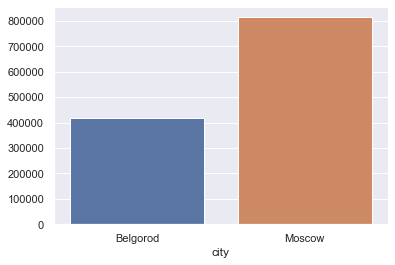

In [170]:
dff = df.groupby(['city'])['profit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

## 1.2 Заполняемость рейса по пассажирам 

<AxesSubplot:xlabel='city'>

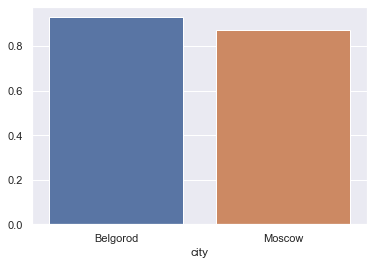

In [171]:
dff = df.groupby(['city'])['occupancy'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

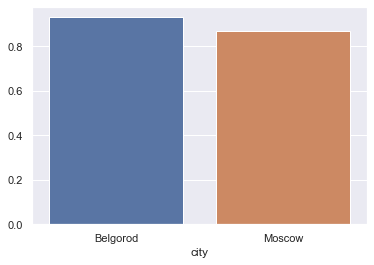

In [172]:
dff = df.groupby(['city'])['occupancy_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

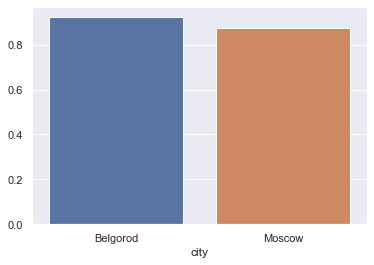

In [173]:
dff = df.groupby(['city'])['occupancy_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

### 1.3 Доля типов пассажирских классов в общую сумму прибыли

<AxesSubplot:xlabel='city'>

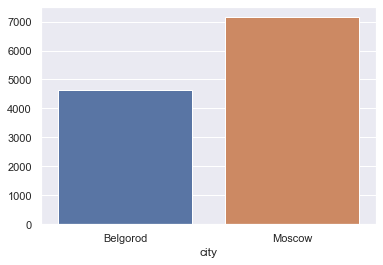

In [180]:
dff = df.groupby(['city'])['deposit_profit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

In [175]:
dff = df.groupby(['city'])['deposit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

KeyError: 'Column not found: deposit'

<AxesSubplot:xlabel='city'>

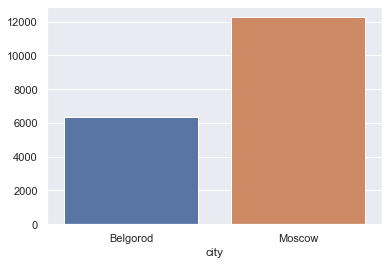

In [182]:
dff = df.groupby(['city'])['deposit_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

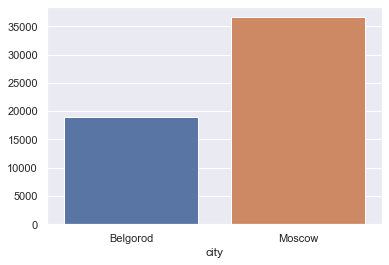

In [183]:
dff = df.groupby(['city'])['deposit_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

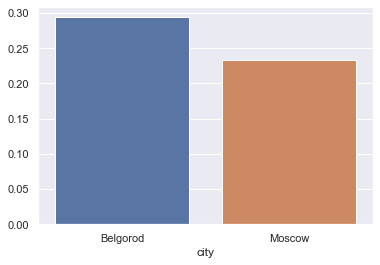

In [184]:
dff = df.groupby(['city'])['part_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

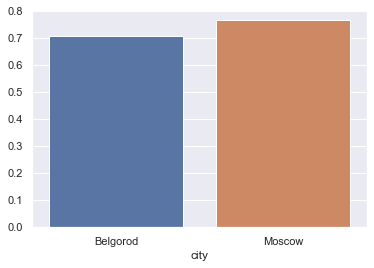

In [185]:
dff = df.groupby(['city'])['part_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city', ylabel='profit'>

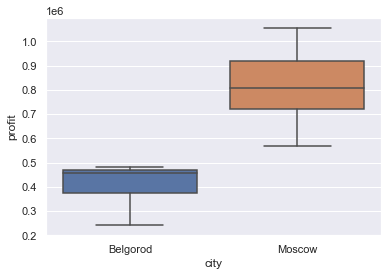

In [186]:
seaborn.boxplot(x=df['city'], y=df['profit'],
            data=df)

### График зависимости прибыли от заполняемости рейса

<AxesSubplot:xlabel='occupancy', ylabel='profit'>

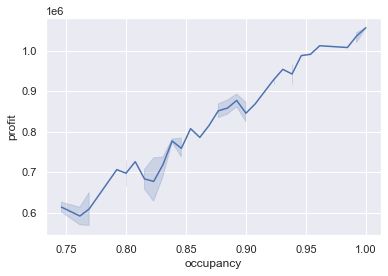

In [197]:
Moscow_city = df[df['city'] == 'Moscow' ].copy()
seaborn.lineplot(x='occupancy', y='profit', data=Moscow_city)

<AxesSubplot:xlabel='occupancy', ylabel='profit'>

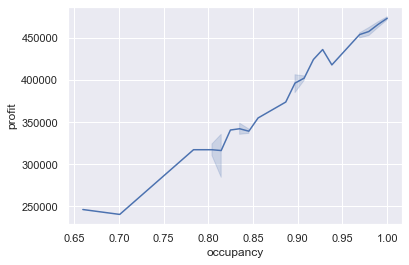

In [198]:
Belgorod_city = df[df['city'] == 'Belgorod' ].copy()
seaborn.lineplot(x='occupancy', y='profit', data=Belgorod_city)

In [200]:
low_profit = df[df['profit'] < 300000].copy()
low_profit[['flight_id', 'date_departure', 'city', 'occupancy', 'profit']]

,flight_id,date_departure,city,occupancy,profit
96,136807,2017-02-23 09:28:00,Belgorod,0.701031,240589.600
118,136844,2017-02-28 09:26:00,Belgorod,0.814433,284689.600
122,136642,2017-01-30 09:28:00,Belgorod,0.659794,246397.808


<AxesSubplot:xlabel='occupancy', ylabel='profit'>

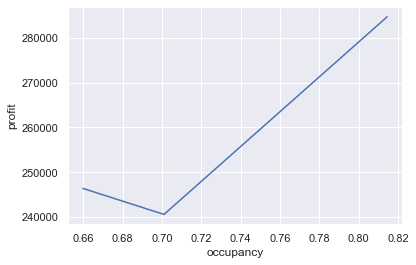

In [201]:

seaborn.lineplot(x='occupancy', y='profit', data=low_profit)